In [1]:
from collections import Counter
import pathlib
from typing import Dict, List
import warnings
import yaml

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import optuna
from optuna.samplers import TPESampler
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit


warnings.simplefilter('ignore')

/home/ss/miniconda3/envs/optiver/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def train_using_cv(
        dataset: pd.DataFrame,
        kfold_params: Dict,
        outputs_dir: pathlib.Path,
    ):
    
    kfold = TimeSeriesSplit(**kfold_params)
    target_columns = ['target']
    feature_columns = [
        col for col in dataset.columns
        if col not in ['stock_id', 'date_id', 'target', 'time_id', 'row_id']
    ]
    time = np.arange(dataset['date_id'].min(), dataset['date_id'].max())
    oof_true = []
    oof_pred = []
    fimps = []
    best_param_records = {}
    best_value_records = {}
    history = {
        'train_mae': [],
        'valid_mae': [],
    }
    for k, (train_indices, valid_indices) in enumerate(kfold.split(time)):
        #if k != 4: continue
        print(f'fold {k+1}')
        train_time = time[train_indices]
        valid_time = time[valid_indices]
        print(train_time.shape, np.min(train_time), np.max(train_time))
        print(valid_time.shape, np.min(valid_time), np.max(valid_time))

        _, ax = plt.subplots()
        ax.barh(y='all', height=0.6, width=len(time), left=0, color='tab:blue')
        ax.barh(y='train+valid', height=0.6, width=[len(train_time), len(valid_time)],
                left=[train_time.min(), valid_time.min()], color=['tab:orange', 'tab:green'])
        xcenter = [len(time)//2, train_time.min()+len(train_time)//2, valid_time.min()+len(valid_time)//2]
        ycenter = [0, 1, 1]
        width = [len(time), len(train_time), len(valid_time)]
        for x, y, w in zip(xcenter, ycenter, width):
            ax.text(x, y, str(w),  ha='center', va='center')
        if kfold_params['gap'] > 0:
            ax.set_xticks([train_time.min(), train_time.max(), valid_time.min(), valid_time.max(), time.max()])
        else:
            ax.set_xticks([train_time.min(), train_time.max(), valid_time.max(), time.max()])
        ax.grid(axis='x', linestyle='--')
        ax.tick_params(axis='x', labelrotation=45)
        plt.show()
        
        train_X = dataset.query('date_id in @train_time')[feature_columns].values
        train_y = dataset.query('date_id in @train_time')[target_columns].values.reshape(-1)
        valid_X = dataset.query('date_id in @valid_time')[feature_columns].values
        valid_y = dataset.query('date_id in @valid_time')[target_columns].values.reshape(-1)
        print(f'train_X.shape: {train_X.shape}, train_y.shape: {train_y.shape}')
        print(f'valid_X.shape: {valid_X.shape}, valid_y.shape: {valid_y.shape}')
        
        best_param_records[f'fold{k+1}'] = {}
        best_value_records[f'fold{k+1}'] = {}

        objective = Objective(train_X, train_y, valid_X, valid_y)
        study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=42))
        optuna.logging.set_verbosity(optuna.logging.WARNING)
        study.optimize(objective, n_trials=1)
        best_params = study.best_params
        add_params = {
            'task': 'train',
            'boosting_type': 'gbdt',
            'objective': 'mae',
            'metric': 'mae',
            'seed': 42,
        }
        best_params.update(add_params)

        [print(f'{k}: {v}') for k, v in best_params.items()]
        print(f'best value: {study.best_value}')

        best_param_records[f'fold{k+1}'] = best_params
        best_value_records[f'fold{k+1}'] = study.best_value
        callbacks = [
            lgb.early_stopping(stopping_rounds=100, verbose=True),
            lgb.log_evaluation(100),
        ]
        
        train_dataset = lgb.Dataset(train_X, train_y)
        valid_dataset = lgb.Dataset(valid_X, valid_y)
        
        model = lgb.train(
            params=best_params,
            train_set=train_dataset,
            valid_sets=[train_dataset, valid_dataset],
            valid_names=['train', 'valid'],
            callbacks=callbacks,
            num_boost_round=3000,
        )
        model.save_model(
            outputs_dir.joinpath(f'lightgbm_optuna_group_fold{k+1}'),
            num_iteration=model.best_iteration
        )

        fimp = model.feature_importance(importance_type='gain')
        fimp = pd.DataFrame(fimp, index=feature_columns, columns=[f'fold{k+1}'])
        fimps.append(fimp)
        
        oof_true.append(valid_y)
        oof_pred.append(model.predict(valid_X))

        history['train_mae'] = np.mean(abs(train_y - model.predict(train_X)))
        history['valid_mae'] = np.mean(abs(valid_y - model.predict(valid_X)))
    
    fimps = pd.concat(fimps, axis=1)

    mean_fimps = fimps.mean(axis=1)
    std_fimps = fimps.std(axis=1)
    fimps['mean_fimps'] = mean_fimps
    fimps['std_fimps'] = std_fimps
    fimps.sort_values(by='mean_fimps', inplace=True)
    display(fimps)
    
    fimps['mean_fimps'].plot(kind='barh', xerr=fimps['std_fimps'], capsize=3)
    plt.show()
    
    oof_true = np.concatenate(oof_true)
    oof_pred = np.concatenate(oof_pred)
    oof_mae = np.mean(abs(oof_true - oof_pred))
    print(f'oof mae: {oof_mae:.4f}')
    
    with open(outputs_dir.joinpath('result_lightgbm_optuna.yaml'), 'w') as f:
        yaml.dump(
            {
                'best_param_records': best_param_records,
                'best_value_records': best_value_records,
                'oof rmse': oof_mae.item(),
            },
            f,
            default_flow_style=False
        )
    return pd.DataFrame.from_dict(history)


class Objective:
    def __init__(self, train_X, train_y, valid_X, valid_y):
        self.train_X = train_X
        self.train_y = train_y
        self.valid_X = valid_X
        self.valid_y = valid_y

    def __call__(self, trial):
        params = {
            'task': 'train',
            'boosting_type': 'gbdt',
            'objective': 'mae',
            'metric': 'mae',
            'learning_rate': trial.suggest_float('learning_rate', 1e-03, 1e-01),
            'seed': 42,
            'max_depth':  trial.suggest_int('max_depth', 3, 10),
            #'num_leaves': trial.suggest_int('max_depth', 31, 127),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 100),
            'feature_fraction': trial.suggest_float('feature_fraction', 0.2, 1.0),
            'feature_fraction_bynode': trial.suggest_float('feature_fraction_bynode', 0.2, 1.0),
            #'lambda_l2': trial.suggest_float('lambda_l2', 0.1, 10),
            'verbose': -1,
        }
        
        callbacks = [
            lgb.early_stopping(stopping_rounds=100, verbose=True),
            lgb.log_evaluation(0),
        ]
        train_dataset = lgb.Dataset(self.train_X, self.train_y)
        valid_dataset = lgb.Dataset(self.valid_X, self.valid_y)
        model = lgb.train(
            params=params,
            train_set=train_dataset,
            valid_sets=[train_dataset, valid_dataset],
            valid_names=['train', 'valid'],
            callbacks=callbacks,
            num_boost_round=trial.suggest_int('num_boost_round', 500, 3000),
        )

        preds = model.predict(self.valid_X)
        mae = np.mean(abs(preds - self.valid_y))
        return mae

In [3]:
inputs_dir_path = pathlib.Path('../inputs')
outputs_dir_path = pathlib.Path('../outputs')
if not outputs_dir_path.is_dir():
    outputs_dir_path.mkdir()

train_ez_df = pd.read_csv(outputs_dir_path.joinpath('train_ez.csv'))
train_ez_df = train_ez_df.dropna(subset=['target'])
train_ez_df['diff_ask_bid_price'] = train_ez_df['ask_price'] - train_ez_df['bid_price']
train_ez_df['sum_ask_bid_price'] = train_ez_df['ask_price'] + train_ez_df['bid_price']
train_ez_df['diff_ask_bid_size'] = train_ez_df['ask_size'] - train_ez_df['bid_size']
train_ez_df['sum_ask_bid_size'] = train_ez_df['ask_size'] + train_ez_df['bid_size']
display(train_ez_df)

train_not_ez_df = pd.read_csv(outputs_dir_path.joinpath('train_not_ez.csv'))
train_not_ez_df = train_not_ez_df.dropna(subset=['target'])
train_not_ez_df['diff_ask_bid_price'] = train_not_ez_df['ask_price'] - train_not_ez_df['bid_price']
train_not_ez_df['sum_ask_bid_price'] = train_not_ez_df['ask_price'] + train_not_ez_df['bid_price']
train_not_ez_df['diff_ask_bid_size'] = train_not_ez_df['ask_size'] - train_not_ez_df['bid_size']
train_not_ez_df['sum_ask_bid_size'] = train_not_ez_df['ask_size'] + train_not_ez_df['bid_size']
display(train_not_ez_df)

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,...,ask_price,ask_size,wap,target,time_id,row_id,diff_ask_bid_price,sum_ask_bid_price,diff_ask_bid_size,sum_ask_bid_size
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,...,1.000026,8493.03,1.000000,-3.029704,0,0_0_0,0.000214,1.999838,-52158.47,69144.53
1,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,...,1.000214,479032.40,1.000000,-4.010200,0,0_0_3,0.000215,2.000213,476707.50,481357.30
2,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,...,1.000016,434.10,1.000000,-7.349849,0,0_0_4,0.000622,1.999410,-16051.44,16919.64
3,9,0,0,3039700.65,-1,1.000969,6248958.45,NaN,NaN,0.999354,...,1.000646,6199.00,1.000000,7.970333,0,0_0_9,0.001292,2.000000,8.00,12390.00
4,10,0,0,10482752.19,-1,1.001374,8839457.10,NaN,NaN,0.999885,...,1.001321,217098.37,1.000000,5.350113,0,0_0_10,0.001436,2.001206,198296.37,235900.37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2642164,192,480,540,67162.62,1,1.000762,11790079.43,1.000834,1.000762,1.000545,...,1.000762,69841.50,1.000698,-1.729727,26454,480_540_192,0.000217,2.001307,-98571.36,238254.36
2642165,193,480,540,6500948.04,1,1.001599,80357531.06,1.002908,1.002326,1.001454,...,1.001599,363532.53,1.001531,-3.880262,26454,480_540_193,0.000145,2.003053,-49609.71,776674.77
2642166,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,...,1.000434,319862.40,1.000328,2.310276,26454,480_540_195,0.000117,2.000751,287605.36,352119.44
2642167,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,...,1.000900,93393.07,1.000819,-8.220077,26454,480_540_196,0.000257,2.001543,-111715.33,298501.47


,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,...,ask_price,ask_size,wap,target,time_id,row_id,diff_ask_bid_price,sum_ask_bid_price,diff_ask_bid_size,sum_ask_bid_size
0,1,0,0,166603.91,-1,0.999896,1.642214e+06,NaN,NaN,0.999896,...,1.000660,20605.09,1.000000,-5.519986,0,0_0_1,0.000764,2.000556,17372.05,23838.13
1,2,0,0,302879.87,-1,0.999561,1.819368e+06,NaN,NaN,0.999403,...,1.000298,18995.00,1.000000,-8.389950,0,0_0_2,0.000895,1.999701,-18961.00,56951.00
2,5,0,0,0.00,0,1.000635,1.355288e+07,NaN,NaN,0.999779,...,1.000635,5647.65,1.000000,6.779432,0,0_0_5,0.000856,2.000414,3684.93,7610.37
3,6,0,0,969969.40,1,1.000115,3.647504e+06,NaN,NaN,0.999506,...,1.000283,3810.48,1.000000,-2.499819,0,0_0_6,0.000777,1.999789,-2852.68,10473.64
4,7,0,0,9412959.10,1,0.999818,2.126125e+07,NaN,NaN,0.999741,...,1.000130,2570.60,1.000000,-1.959801,0,0_0_7,0.000389,1.999871,-2568.60,7709.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2595718,190,480,540,466320.15,-1,0.999295,3.929472e+07,0.998983,0.999139,0.999295,...,0.999451,169105.20,0.999311,-0.470281,26454,480_540_190,0.000156,1.998746,149379.34,188831.06
2595719,191,480,540,36937785.44,1,0.995983,6.083261e+08,0.999086,0.997746,0.995913,...,0.995983,48025.00,0.995958,0.799894,26454,480_540_191,0.000070,1.991896,-36719.00,132769.00
2595720,194,480,540,262271.52,-1,1.001504,3.922295e+06,1.000677,1.000677,1.001504,...,1.001917,139637.49,1.001557,4.839897,26454,480_540_194,0.000413,2.003421,118808.29,160466.69
2595721,197,480,540,0.00,0,0.995789,1.272544e+07,0.995789,0.995789,0.995789,...,0.995883,180038.32,0.995797,1.169443,26454,480_540_197,0.000094,1.991672,163247.66,196828.98


fold 1
(30,) 0 29
(30,) 30 59


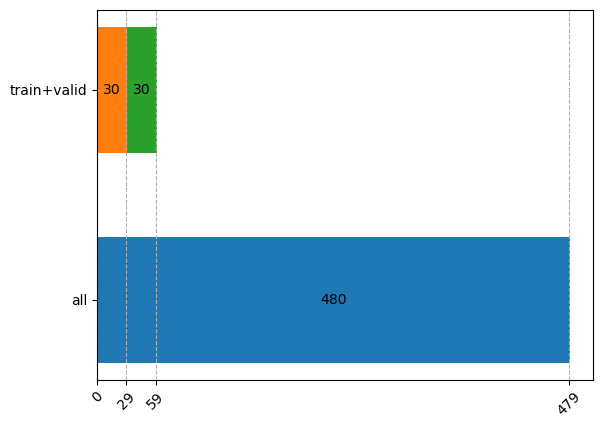

[I 2023-10-19 10:41:05,222] A new study created in memory with name: no-name-9cd9ebb5-51e3-47b4-8acd-ebc7a61de530


train_X.shape: (163350, 16), train_y.shape: (163350,)
valid_X.shape: (163374, 16), valid_y.shape: (163374,)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[113]	train's l1: 3.62393	valid's l1: 3.93571
learning_rate: 0.03807947176588889
max_depth: 10
min_data_in_leaf: 79
feature_fraction: 0.6789267873576292
feature_fraction_bynode: 0.3248149123539492
num_boost_round: 890
task: train
boosting_type: gbdt
objective: mae
metric: mae
seed: 42
best value: 3.9357058456154417
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001303 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_w

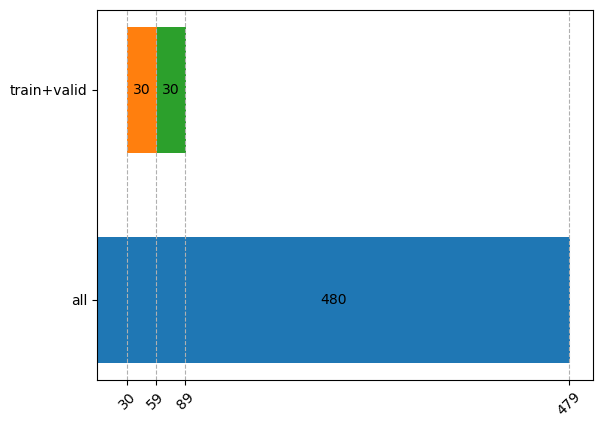

train_X.shape: (163374, 16), train_y.shape: (163374,)
valid_X.shape: (165000, 16), valid_y.shape: (165000,)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[226]	train's l1: 3.84025	valid's l1: 4.80312
learning_rate: 0.03807947176588889
max_depth: 10
min_data_in_leaf: 79
feature_fraction: 0.6789267873576292
feature_fraction_bynode: 0.3248149123539492
num_boost_round: 890
task: train
boosting_type: gbdt
objective: mae
metric: mae
seed: 42
best value: 4.803122149514408
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3628
[LightGBM] [Info] Nu

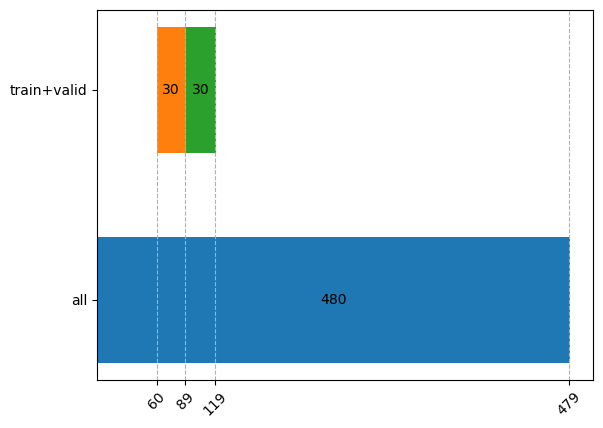

train_X.shape: (165000, 16), train_y.shape: (165000,)
valid_X.shape: (165000, 16), valid_y.shape: (165000,)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[142]	train's l1: 4.71802	valid's l1: 5.19458
learning_rate: 0.03807947176588889
max_depth: 10
min_data_in_leaf: 79
feature_fraction: 0.6789267873576292
feature_fraction_bynode: 0.3248149123539492
num_boost_round: 890
task: train
boosting_type: gbdt
objective: mae
metric: mae
seed: 42
best value: 5.194582888547039
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001438 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3628
[LightGBM] [Info] Nu

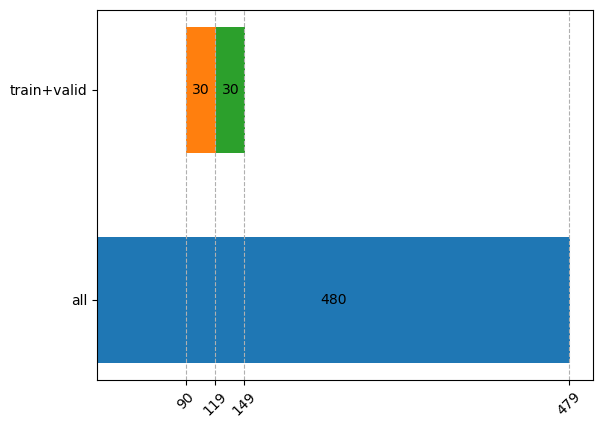

train_X.shape: (165000, 16), train_y.shape: (165000,)
valid_X.shape: (165000, 16), valid_y.shape: (165000,)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[300]	train's l1: 5.03953	valid's l1: 5.96541
learning_rate: 0.03807947176588889
max_depth: 10
min_data_in_leaf: 79
feature_fraction: 0.6789267873576292
feature_fraction_bynode: 0.3248149123539492
num_boost_round: 890
task: train
boosting_type: gbdt
objective: mae
metric: mae
seed: 42
best value: 5.965414010207145
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000789 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wi

In [4]:
kfold_params = {
    'n_splits': 15,
    'max_train_size': 30,
    'test_size': 30,
    'gap': 0,
}

history = train_using_cv(
    kfold_params=kfold_params,
    dataset=train_ez_df,
    outputs_dir=outputs_dir_path,
)

In [ ]:
print(history)